# Conditional Random Field implementation
## Using small number of demonstrations, no adversarial data
### My own implmentation no success

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import gym
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

### Load Expert Data 

In [2]:
# Load the expert data
data = pd.read_table(
    'mountain_car_demo.txt',
    sep=' ',
    header=0,
    names=['pos', 'vel', 'action', 'reward'],
    skiprows=1,
    index_col=False
)
data

,pos,vel,action,reward
0,-0.422633,-0.001758,0.0,-1.0
1,-0.426137,-0.003504,0.0,-1.0
2,-0.431361,-0.005225,0.0,-1.0
3,-0.438269,-0.006908,0.0,-1.0
4,-0.446809,-0.008541,0.0,-1.0
...,...,...,...,...
1247,0.344660,0.035769,2.0,-1.0
1248,0.380151,0.035491,2.0,-1.0
1249,0.415599,0.035448,2.0,-1.0
1250,0.451251,0.035652,2.0,-1.0


### Visualize data

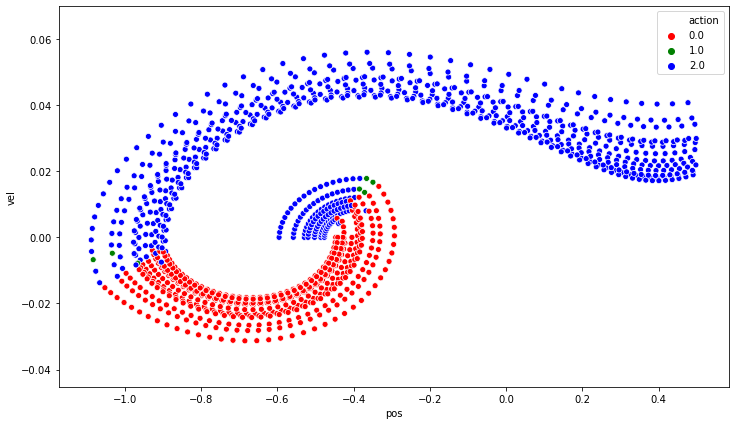

In [3]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data.pos, data.vel, hue=data.action, palette=['red', 'green', 'blue' ])

### Transform Data into a set of sequences

In [10]:
demos = [
    [0, 84],
    [85, 190],
    [191, 293],
    [294, 398],
    [399, 487],
    [488, 591],
    [592, 693],
    [694, 777],
    [778, 867],
    [868, 954],
    [955, 1057],
    [1058, 1146],
    [1147, 1251]
]
seqs = np.empty(len(demos), dtype=object)

for k, demo in enumerate(demos):
    
    seqs[k] = np.array(
        [
            [
                data.pos[i],
                data.vel[i],
                data.action[i]
            ]
            for i in range(demo[0], demo[1]+1)
        ]
    )
actions = [0, 1, 2]
position = [False, True]
velocity = [False, True]

In [11]:
from sklearn.feature_extraction import DictVectorizer
feature_extractor = DictVectorizer(sparse=False)

In [12]:
all_combinations = []
for prev_action in actions:
    for next_action in actions:
        for pos in position:
            for vel in velocity:
                mapping = {
                    'prev_action': prev_action,
                    'next_action': next_action,
                    'position': pos,
                    'velocity': vel
                }
                all_combinations.append(mapping)
                
all_possible = feature_extractor.fit_transform(all_combinations)

In [23]:
sequences = np.empty(len(seqs), dtype=object)
for i, seq in enumerate(seqs):
    values = []
    for k in range(len(seq)):
        
        mapping = {
            'prev_action': seq[k-1][2] if k > 0 else np.random.randint(0,3),
            'next_action': seq[k][2],
            'position': seq[k-1][0] > seq[k][0] if k > 0 else False,
            'velocity': seq[k-1][1] > seq[k][1] if k > 0 else False
        }
        values.append(mapping)
        
    sequences[i] = feature_extractor.transform(values)

In [35]:
def gradient_A(seqs):
    
    def gradient_A_one_seq(seq):
        
        return np.sum(seq, axis=0)
    
    return np.sum(
        np.array(
            [
                gradient_A_one_seq(seq)
                for seq in seqs
            ]
        ),
        axis=0
    )

In [36]:
grad_A = gradient_A(sequences)

In [37]:
grad_A

array([1497.,  488., 1485.,  566.])

In [44]:
all_possible2 = np.empty((4, 3, 3, 4), dtype=np.int32)
state_space = [(True, True), (True, False), (False, True), (False, False)]
for k, state in enumerate(state_space):
     for i, prev in enumerate(actions):
            for j, next_ in enumerate(actions):
                
                all_possible2[k][i][j] = feature_extractor.transform(
                    {
                        'prev_action': prev,
                        'next_action': next_,
                        'position': state[0],
                        'velocity': state[1]
                    }
                )
state_to_idx = {}

for i in range(len(state_space)):
    state_to_idx[state_space[i]] = i

### Alpha and Beta Trellis

In [71]:
# p: prev action
# n: next action
# f: feature

def alpha_trellis(w, seq):
    
    alphas = np.ones((seq.shape[0]+1, len(actions)))
    
    for k in range(1, len(seq)):
        
        alphas[k] = np.einsum(
            'p, pn -> p',
            alphas[k-1],
            #np.exp(
                np.einsum(
                    'f, pnf -> pn',
                    w, 
                    all_possible2[
                        state_to_idx[
                            (seq[k-1][0]>seq[k][0], seq[k-1][1]>seq[k][1])
                        ]
                    ]
                )
            #)
        )
    return alphas, np.sum(alphas[len(seq)-1])

def beta_trellis(w, seq):
    
    betas = np.ones((seq.shape[0]+1, len(actions)))
    
    for k in reversed(range(1, len(seq))):
        
        betas[k] = np.einsum(
            'n, np -> n',
            betas[k+1],
            #np.exp(
                np.einsum(
                    'f, pnf -> np',
                    w, 
                    all_possible2[
                        state_to_idx[
                            (seq[k-1][0]>seq[k][0], seq[k-1][1]>seq[k][1])
                        ]
                    ]
                )
            #)
        )
    return betas, np.sum(betas[1])

In [72]:
alphas, Z1 = alpha_trellis(np.ones(4), sequences[0])
betas, Z2 = beta_trellis(np.ones(4), sequences[0])
Z1, Z2

(1.9112149306223773e+80, 1.9112149306223773e+80)

In [73]:
Z1 - Z2

0.0